# Segmentation


## Lien Kaggle

- https://www.kaggle.com/beezus666/oxford-pets-keras-tf-hub-base/notebook
- https://www.kaggle.com/yosshi999/oxfordiiit-pet-segmentation

In [63]:
%reset -f

In [64]:
%matplotlib inline
import gc
import os

import glob
from PIL import Image
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.random import set_seed
from numpy.random import seed
import random

def seed_all_inclusive(seeding):
    random.seed(seeding)
    seed(seeding)
    os.environ['PYTHONHASHSEED'] = str(seeding)
    set_seed(seed=seeding)
seed_all_inclusive(1) 
gc.collect()
seeding = 1
img_size=256
repeat_epoch=40

In [65]:
image_list = []
for file in os.listdir("./images"):
    if file.endswith(".jpg"):
        print(file)
        image_list.append(file)


Birman_115.jpg
leonberger_142.jpg
Bombay_68.jpg
japanese_chin_26.jpg
saint_bernard_149.jpg
Ragdoll_41.jpg
japanese_chin_32.jpg
Ragdoll_68.jpg
Persian_202.jpg
scottish_terrier_143.jpg
english_setter_157.jpg
Bombay_215.jpg
havanese_80.jpg
Bengal_69.jpg
great_pyrenees_24.jpg
basset_hound_11.jpg
Egyptian_Mau_127.jpg
american_bulldog_146.jpg
english_cocker_spaniel_15.jpg
newfoundland_156.jpg
great_pyrenees_165.jpg
newfoundland_116.jpg
saint_bernard_140.jpg
Birman_39.jpg
american_pit_bull_terrier_19.jpg
samoyed_177.jpg
english_cocker_spaniel_167.jpg
american_pit_bull_terrier_118.jpg
staffordshire_bull_terrier_108.jpg
Bengal_152.jpg
Persian_98.jpg
shiba_inu_9.jpg
american_pit_bull_terrier_12.jpg
japanese_chin_144.jpg
german_shorthaired_196.jpg
english_setter_8.jpg
miniature_pinscher_63.jpg
leonberger_18.jpg
american_pit_bull_terrier_108.jpg
miniature_pinscher_112.jpg
yorkshire_terrier_124.jpg
Egyptian_Mau_105.jpg
samoyed_25.jpg
staffordshire_bull_terrier_140.jpg
chihuahua_54.jpg
american_pit_

In [66]:
pet_df = pd.DataFrame(np.nan, index=np.arange(
    len(image_list)), columns=['pet_images'])
pet_df['pet_images'] = image_list
pet_df['image_name'] = pet_df.pet_images.str.split(pat='.', expand=True)[0]
pet_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7390 entries, 0 to 7389
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   pet_images  7390 non-null   object
 1   image_name  7390 non-null   object
dtypes: object(2)
memory usage: 173.2+ KB


(375, 500, 3)


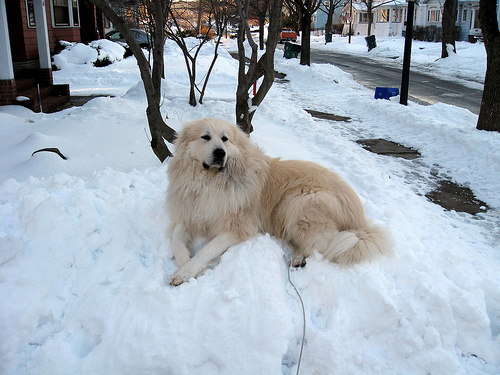

In [67]:
i = 50
IM_name = './images/' + \
    pet_df['image_name'].iloc[i]
a = cv2.imread(IM_name+'.jpg')
print(a.shape)
a = Image.open(IM_name+'.jpg')
a


In [68]:
os.mkdir('masks')


In [69]:
# IM_name = './masks/' + pet_df['image_name'].iloc[i]
# a = cv2.imread(IM_name+'.png')
# print(a.shape)
# a = Image.open('.trimaps/' + IM_name+'.png')
# Image.fromarray(a.astype(np.uint8)*255)


In [70]:
count = 0
outdir = 'masks/'
for i in range(len(image_list)):
    IM_name = pet_df['image_name'].iloc[i]
    imgs = cv2.imread('./annotations/trimaps/' + IM_name+'.png')
    # print(imgs.shape)
    a = Image.open('./annotations/trimaps/' + IM_name+'.png')
    imgs = ((imgs[:, :, :] == 1)).astype(np.uint8)
    imgs = imgs[:, :, 0] + imgs[:, :, 1]+imgs[:, :, 2]
    imgs = ((imgs[:, :] > 0)).astype(np.uint8)*255

    imgs = cv2.resize(imgs, (img_size, img_size), interpolation=cv2.INTER_AREA)

    cv2.imwrite(outdir + IM_name + '.png', imgs)  # write png image

    count = count+1
    if count % 1001 == 0:
        print(i, imgs.shape)

    del imgs


1000 (256, 256)
2001 (256, 256)
3002 (256, 256)
4003 (256, 256)
5004 (256, 256)
6005 (256, 256)
7006 (256, 256)


# Training and scores

In [87]:
import os
import warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing import image
import keras
import glob

# Reproducability


def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'


set_seed()


In [72]:
dir_name='./images/*'
#not sure what's going on with directory names in Kaggle, but needed the asterik to get it to work with glob

pets_files = glob.glob(dir_name) 
pets_df = pd.DataFrame(pets_files)
pets_df.columns =['full_path']
pets_df['file_name'] = pets_df['full_path'].str.split('images/').str[1]

# labels in this dataset are in the file name
pets_df['label'] = pets_df['file_name'].str.rsplit('_',1).str[0]
pets_df.tail()

,full_path,file_name,label
7388,./images/havanese_89.jpg,havanese_89.jpg,havanese
7389,./images/saint_bernard_30.jpg,saint_bernard_30.jpg,saint_bernard
7390,./images/newfoundland_200.jpg,newfoundland_200.jpg,newfoundland
7391,./images/yorkshire_terrier_181.jpg,yorkshire_terrier_181.jpg,yorkshire_terrier
7392,./images/german_shorthaired_66.jpg,german_shorthaired_66.jpg,german_shorthaired


In [73]:
%%time
datagen = image.ImageDataGenerator(rescale=1/255., validation_split=0.2)
train_generator = datagen.flow_from_dataframe(dataframe=pets_df, 
                                              directory= '../input/the-oxfordiiit-pet-dataset/images/images',
                                              #again not sure what's up with directories, took awhile to figure out I needed that ending /images
                                             x_col='file_name',
                                             y_col='label',
                                             target_size=(224,224),
                                             class_mode='categorical',
                                             batch_size=100,
                                             subset='training'
                                             )

validation_generator = datagen.flow_from_dataframe(dataframe=pets_df,
                                                   directory= '../input/the-oxfordiiit-pet-dataset/images/images',
                                                   x_col='file_name',                                                   
                                             y_col='label',
                                             target_size=(224,224),
                                             class_mode='categorical',
                                             batch_size=10,
                                             subset='validation',
                                             seed=7)

Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.
CPU times: user 179 ms, sys: 28.8 ms, total: 207 ms
Wall time: 205 ms


/home/daftvm/anaconda3/envs/deepl/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 7393 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  warnings.warn(


In [77]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"
resnset50 = 'https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5'
classifier_model = inception_v3

In [85]:
pretrained_base = hub.KerasLayer(classifier_model, trainable = False) #input_shape=IMAGE_SHAPE+(3,))
model = keras.Sequential([
    pretrained_base,
    keras.layers.Flatten(),
    keras.layers.Dense(6, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

TypeError: The added layer must be an instance of class Layer. Found: <tensorflow_hub.keras_layer.KerasLayer object at 0x7f7b8e39e670>

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

#optimizer = tf.keras.optimizers.Adam(epsilon=0.01)

model.compile(
    optimizer=optimizer,
    loss = 'categorical_crossentropy',
    metrics=['accuracy'],
)
# model.save('model.csv')

In [ ]:
history = model.fit(
    train_generator,
    validation_data= validation_generator,
    epochs=3,
)